In [1]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="0EKSrlH9OVngYfgQCrauwqLEt",
                        project_name="mri-interpretation", workspace="polina")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/polina/mri-interpretation/013e9eb6d2d0476695aff72ee0307a46



In [2]:
# !pip install torchio

In [3]:
import numpy as np
import functools
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
# from torchsummary import summary
import os
import pathlib
from sklearn.model_selection import train_test_split, StratifiedKFold
import torchio
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import *
import random
%matplotlib inline

In [4]:
import nilearn
from nilearn import plotting

In [5]:
from data import HCP_MRI

In [6]:
 torch.cuda.is_available()

True

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [10]:
!nvidia-smi

Sun Feb  7 21:13:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:13:00.0 Off |                    0 |
| N/A   23C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   28C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Data

In [11]:
data_dir = pathlib.Path('/data/adni')

In [12]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
# plot_central_cuts(nilearn.image.get_data(img)[np.newaxis,:], title="ex", t = None)
# plot_central_cuts(img_crop, title="ex", t = None)

In [13]:
PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join('/data/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

In [14]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

In [13]:
pd.read_csv(behavioral_path)

,Subject,Gender,Release,FS_InterCranial_Vol,FS_BrainSeg_Vol,FS_BrainSeg_Vol_No_Vent,FS_BrainSeg_Vol_No_Vent_Surf,FS_LCort_GM_Vol,FS_RCort_GM_Vol,FS_TotCort_GM_Vol,...,FS_R_Rostralanteriorcingulate_CurvInd,FS_R_Rostralmiddlefrontal_CurvInd,FS_R_Superiorfrontal_CurvInd,FS_R_Superiorparietal_CurvInd,FS_R_Superiortemporal_CurvInd,FS_R_Supramarginal_CurvInd,FS_R_Frontalpole_CurvInd,FS_R_Temporalpole_CurvInd,FS_R_Transversetemporal_CurvInd,FS_R_Insula_CurvInd
0,100206,M,S900,1.864518e+06,1406924.0,1389007.0,1.386836e+06,304488,305634,610122,...,5.6,34.6,40.1,23.3,15.6,11.9,2.9,3.8,2.8,37.5
1,100307,F,Q1,1.512540e+06,1109710.0,1098854.0,1.097122e+06,240030,243207,483238,...,3.3,29.9,48.8,21.6,18.6,15.0,2.9,5.8,2.0,30.2
2,100408,M,Q3,1.684117e+06,1280171.0,1260943.0,1.259250e+06,260695,265243,525938,...,3.3,25.2,27.5,15.2,13.9,12.3,1.8,7.8,1.9,25.1
3,100610,M,S900,1.816044e+06,1321362.0,1306929.0,1.304569e+06,276506,278002,554508,...,3.0,19.6,20.0,18.6,10.6,10.8,1.2,4.1,1.4,16.6
4,101006,F,S500,1.437868e+06,1053766.0,1038408.0,1.037793e+06,203718,210539,414257,...,2.9,14.7,21.3,13.2,8.7,9.8,1.1,3.0,1.0,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,992774,M,Q2,1.519017e+06,1136193.0,1115715.0,1.113862e+06,232242,235740,467982,...,3.4,16.2,18.7,11.5,8.3,8.6,0.6,2.6,0.9,16.6
1109,993675,F,S900,1.408199e+06,1037401.0,1020944.0,1.019593e+06,233533,246215,479748,...,2.3,15.6,23.5,16.4,6.4,9.1,1.1,4.0,0.9,17.4
1110,994273,M,S500,1.738013e+06,1234076.0,1217881.0,1.216379e+06,258246,268631,526877,...,5.8,24.2,33.8,20.5,16.6,15.9,1.2,4.7,3.4,73.7
1111,995174,M,S1200,1.745369e+06,1253571.0,1240861.0,1.239238e+06,264143,270207,534350,...,3.0,24.0,33.8,11.7,9.8,9.4,2.0,3.5,1.6,27.7


In [13]:
len(os.listdir(PATH_TO_MRI))

1112

In [14]:
len(pd.read_csv(behavioral_path))

1113

In [14]:
X_train, X_test = train_test_split(pd.read_csv(behavioral_path), test_size=0.2, random_state=42) 

HCP absmax before normalization: 435.0126647949219
Train Dataset size: 889
Test Dataset size: 223
Labels distribution: (array([0, 1]), array([482, 407]))

Train example:
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


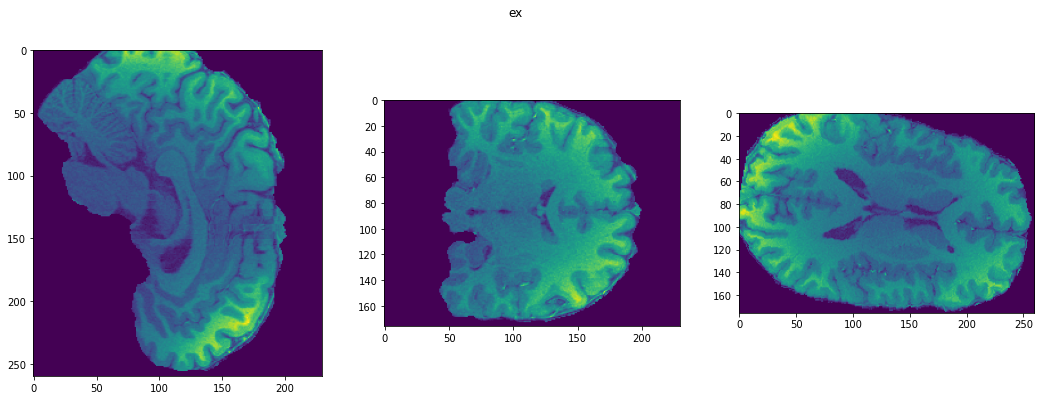

Val example:
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


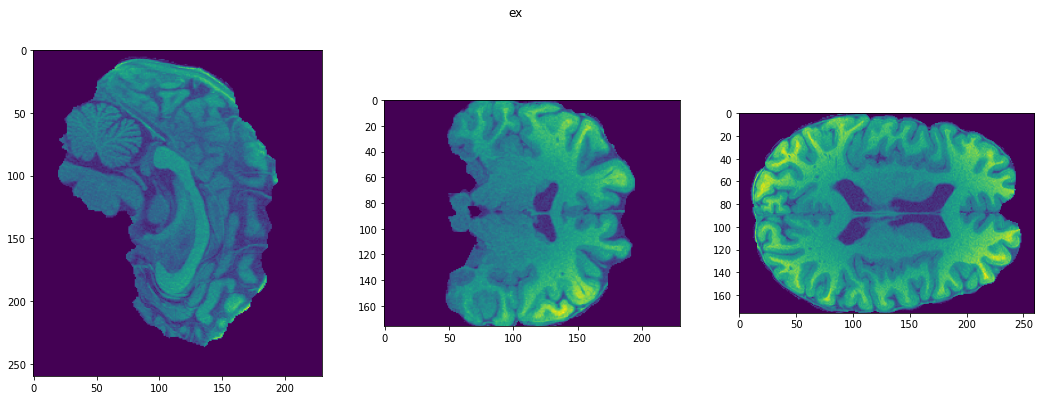

In [15]:
train_hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= X_train,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40,25,55),
    img_shape=(176, 260, 230)
)
val_hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= X_test,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40,25,55),
    img_shape=(176, 260, 230)
)
hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
train_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
val_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
train_transform = Compose([
    ToTensor(),
#     BrightnessContrast(),
#     GaussNoise(),
    RandomRotation(degrees = 55)
#     RandomAffine(degrees = 18, scale=(0.1,1.2))
#     ToTensor(),
])

val_transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
train_hcp_dataset.transform = train_transform
val_hcp_dataset.transform = val_transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Train Dataset size: {}".format(len(train_hcp_dataset)))
print("Test Dataset size: {}".format(len(val_hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(train_hcp_dataset.labels, return_counts=True)))

print("Train example:")
img, target = train_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)
print("Val example:")
img, target = val_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [17]:
def worker_init_fn(_):
    worker_info = torch.utils.data.get_worker_info()
    
    dataset = worker_info.dataset
    worker_id = worker_info.id
    split_size = len(dataset.mri_paths) // worker_info.num_workers
    
    dataset.data = dataset.mri_paths[worker_id * split_size:(worker_id +1) *split_size]

In [16]:
train_loader = torch_data.DataLoader(train_hcp_dataset,
                                          shuffle=True,
                                          batch_size=4)
val_loader = torch_data.DataLoader(val_hcp_dataset,
                                    shuffle=False,
                                    batch_size=2)

In [ ]:
for data, target in tqdm(train_loader):
        out = net(data)

# Model structure

In [15]:
# timing
from tqdm import tqdm

def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    for data, target in tqdm(data_loader):
        data = data.to(device, dtype=torch.float)
        target = target.to(device)
    
        out = net(data)
        loss += criterion(out, target).item()*len(data)

        del data, target, out 

    return loss / len(data_loader.dataset)


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False, experiment= False):
    best_val_loss = 100000 #100_000
    best_val_acc = 0
    best_model = None
#     train_loss_list = []
#     val_loss_list = []
#     train_acc_list = []
#     val_acc_list = []

    train_loss_list = get_loss(net, train_loader)
    val_loss_list= get_loss(net, val_loader)
    train_acc_list = get_accuracy(net, train_loader)
    val_acc_list = get_accuracy(net, val_loader)
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list, val_loss_list))

    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device, dtype=torch.float), y.to(device)
            optimizer.zero_grad()
#             print(type(X))
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            del X, y, out, loss #freeing gpu space
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, y in val_loader:
            # Compute the validation loss
            X, y = X.to(device, dtype=torch.float), y.to(device)
            out = net(X)
            del X, y, out #freeing gpu space
         
        train_loss_list = get_loss(net, train_loader)
        val_loss_list = get_loss(net, val_loader)
        train_acc_list = get_accuracy(net, train_loader)
        val_acc_list = get_accuracy(net, val_loader)
        
        if scheduler is not None:
            scheduler.step(val_acc_list)

        if save and val_acc_list > best_val_acc:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_acc_model_' + model_name)    
            best_val_acc = val_acc_list
            
        if save and val_loss_list < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_val_loss_model_' + model_name)
            best_val_loss = val_loss_list
            
        if save and epoch%10==0:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + str(epoch) + '_epoch_model_' + model_name)
            
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f} Acc: Train {:.4f} | Validation'.format(epoch, epochs, train_loss_list, val_loss_list, train_acc_list, val_acc_list ))
        if experiment:
                experiment.log_metric("train_loss", train_loss_list)
                experiment.log_metric("validate_loss", val_loss_list)
                experiment.log_metric("train_acc", train_acc_list)
                experiment.log_metric("validate_acc", val_acc_list)
                experiment.log_epoch_end(epoch)
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list    

In [18]:
CHECKPOINTS_DIR =  '/home/Druzhinina/project/checkpoints_rot_55_batch6/'

In [16]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2,),
                
                nn.Conv3d(c, 2*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1896960, out_features=2), #4*c*5*7*5
        )
        self.gradients = None
        
     
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [20]:
if torch.cuda.device_count() > 1:
    d_ids= [0,1,2,3]
    print("Let's use", d_ids, "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model, device_ids=d_ids)

model.to(device)

Let's use [0, 1, 2, 3] GPUs!


DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_feat

In [21]:
# criterion = nn.NLLLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #return ADAM?
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
criterion = nn.CrossEntropyLoss()


In [22]:
model_name = '_rotation_55_5batch_1e4'
experiment.set_name("3DCNN_rotation_55_5batch_1e4")

In [ ]:
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 40

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 

  0%|          | 0/223 [00:00<?, ?it/s]

In [ ]:
# plt.figure(figsize=(20,8))

# plt.subplot(1, 2, 1)
# plt.title('Loss history', fontsize=18)
# plt.plot(train_loss_list[1:], label='Train')
# plt.plot(val_loss_list[1:], label='Validation')
# plt.xlabel('# of epoch', fontsize=16)
# plt.ylabel('Loss', fontsize=16)
# plt.legend(fontsize=16)
# plt.grid()

# plt.subplot(1, 2, 2)
# plt.title('Accuracy history', fontsize=18)
# plt.plot(train_acc_list, label='Train')
# plt.plot(val_acc_list, label='Validation')
# plt.xlabel('# of epoch', fontsize=16)
# plt.ylabel('Accuracy', fontsize=16)
# plt.legend(fontsize=16)
# plt.grid()

In [26]:
torch.cuda.empty_cache()

In [ ]:
model.load_state_dict(torch.load('/home/mri/Druzhinina/project/checkpoints_work_gradcam/best_acc_model__checkpoints_work_gradcam'))
model.eval()

In [19]:
get_accuracy(model, val_loader)

100%|██████████| 112/112 [01:30<00:00,  1.23it/s]


95.96412658691406

In [19]:
pd.read_csv(behavioral_path)

,Subject,Gender,Release,FS_InterCranial_Vol,FS_BrainSeg_Vol,FS_BrainSeg_Vol_No_Vent,FS_BrainSeg_Vol_No_Vent_Surf,FS_LCort_GM_Vol,FS_RCort_GM_Vol,FS_TotCort_GM_Vol,...,FS_R_Rostralanteriorcingulate_CurvInd,FS_R_Rostralmiddlefrontal_CurvInd,FS_R_Superiorfrontal_CurvInd,FS_R_Superiorparietal_CurvInd,FS_R_Superiortemporal_CurvInd,FS_R_Supramarginal_CurvInd,FS_R_Frontalpole_CurvInd,FS_R_Temporalpole_CurvInd,FS_R_Transversetemporal_CurvInd,FS_R_Insula_CurvInd
0,100206,M,S900,1.864518e+06,1406924.0,1389007.0,1.386836e+06,304488,305634,610122,...,5.6,34.6,40.1,23.3,15.6,11.9,2.9,3.8,2.8,37.5
1,100307,F,Q1,1.512540e+06,1109710.0,1098854.0,1.097122e+06,240030,243207,483238,...,3.3,29.9,48.8,21.6,18.6,15.0,2.9,5.8,2.0,30.2
2,100408,M,Q3,1.684117e+06,1280171.0,1260943.0,1.259250e+06,260695,265243,525938,...,3.3,25.2,27.5,15.2,13.9,12.3,1.8,7.8,1.9,25.1
3,100610,M,S900,1.816044e+06,1321362.0,1306929.0,1.304569e+06,276506,278002,554508,...,3.0,19.6,20.0,18.6,10.6,10.8,1.2,4.1,1.4,16.6
4,101006,F,S500,1.437868e+06,1053766.0,1038408.0,1.037793e+06,203718,210539,414257,...,2.9,14.7,21.3,13.2,8.7,9.8,1.1,3.0,1.0,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,992774,M,Q2,1.519017e+06,1136193.0,1115715.0,1.113862e+06,232242,235740,467982,...,3.4,16.2,18.7,11.5,8.3,8.6,0.6,2.6,0.9,16.6
1109,993675,F,S900,1.408199e+06,1037401.0,1020944.0,1.019593e+06,233533,246215,479748,...,2.3,15.6,23.5,16.4,6.4,9.1,1.1,4.0,0.9,17.4
1110,994273,M,S500,1.738013e+06,1234076.0,1217881.0,1.216379e+06,258246,268631,526877,...,5.8,24.2,33.8,20.5,16.6,15.9,1.2,4.7,3.4,73.7
1111,995174,M,S1200,1.745369e+06,1253571.0,1240861.0,1.239238e+06,264143,270207,534350,...,3.0,24.0,33.8,11.7,9.8,9.4,2.0,3.5,1.6,27.7


In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_vall_acc_list = []
j = 0
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
for X_train, X_test in skf.split(pd.read_csv(behavioral_path),pd.read_csv(behavioral_path).Gender):
    print('Doing {} split'.format(j))
    j += 1
    train_hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= pd.read_csv(behavioral_path).iloc[X_train],
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40,25,55),
    img_shape=(176, 260, 230)
    )
    val_hcp_dataset = HCP_MRI(
        paths= PATH_TO_MRI,
        target_path= pd.read_csv(behavioral_path).iloc[X_test],
        load_online=True,
        hcp_type = hcp_type,
        coord_min=(40,25,55),
        img_shape=(176, 260, 230)
    )
    hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
    train_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
    val_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
    train_transform = Compose([
        ToTensor(),
    #     BrightnessContrast(),
    #     GaussNoise(),
        RandomRotation(degrees = 55)
    #     RandomAffine(degrees = 18, scale=(0.1,1.2))
    #     ToTensor(),
    ])

    val_transform = Compose([
    #     BrightnessContrast(),
    #     GaussNoise(),
    #     Rotate(),
        ToTensor(),
    ])
    train_hcp_dataset.transform = train_transform
    val_hcp_dataset.transform = val_transform

    train_loader = torch_data.DataLoader(train_hcp_dataset,
                                          shuffle=True,
                                          batch_size=2)
    val_loader = torch_data.DataLoader(val_hcp_dataset,
                                    shuffle=False,
                                    batch_size=2)

#     model = mri_model.MriNet(C).to(device)
#     criterion = nn.NLLLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
#     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
    c = 32
    model = MriNetGrad(c)
    if torch.cuda.device_count() > 1:
        d_ids= [0,1,2,3]
        print("Let's use", d_ids, "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model, device_ids=d_ids)
        model.to(device)
    model_name = '_rotation_55_5batch_1e4_{}'.format(j)
    experiment.set_name("3DCNN_rotation_55_5batch_1e4_{}".format(j))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
    criterion = nn.CrossEntropyLoss()
    EPOCHS = 20

    train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 
#     _, _, _, _ = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, device, scheduler=scheduler, save=False, verbose=False) 
    cross_vall_acc_list.append(get_accuracy(model, val_loader, device))
    print(cross_vall_acc_list[-1])
print('Mean cross-validation accuracy (10-folds):', np.mean(cross_vall_acc_list))
print('Std cross-validation accuracy (10-folds):', np.std(cross_vall_acc_list, ddof=1))

Doing 0 split


  0%|          | 0/167 [00:00<?, ?it/s]

Let's use [0, 1, 2, 3] GPUs!
